In [ ]:
# check what is wrong with RPT_Short and how to fix it

In [1]:
import pybamm as pb;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;
from scipy.io import savemat,loadmat;from pybamm import constants,exp;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
for k in range(0,1):
    mpl.rcParams["axes.labelsize"] = fs
    mpl.rcParams["axes.titlesize"] = fs
    mpl.rcParams["xtick.labelsize"] =  fs
    mpl.rcParams["ytick.labelsize"] =  fs
    mpl.rcParams["legend.fontsize"] =  fs
    mpl.rcParams['font.sans-serif'] = ['Times New Roman']
    mpl.rcParams['font.serif'] = ['Times New Roman']
    mpl.rcParams['axes.unicode_minus'] = False
import timeit
start = timeit.default_timer()


In [2]:
Model_0 = pb.lithium_ion.DFN(
    options={
        "particle": "Fickian diffusion", 
        "SEI":"interstitial-diffusion limited", 
        "SEI film resistance":"distributed", 
        "SEI porosity change":"true",
        "lithium plating":"partially reversible"
    }
)

In [3]:
V_max = 4.2;        V_min = 2.5;
cs_Neg_Init = 28920; Diff_SEI = 1.700000000000002e-20;    R_SEI = 2E5;   Bulk_Sol_Con = 4541.0;

chemistry = pb.parameter_sets.Chen2020_coupled
Para_0 = pb.ParameterValues(chemistry=chemistry)
#Para_0["Ambient temperature [K]"] = pybamm.InputParameter("T")
Para_0.update({"Upper voltage cut-off [V]": 4.20})
Para_0.update({"Lower voltage cut-off [V]": 2.50})
Para_0.update({'SEI resistivity [Ohm.m]':R_SEI}) ;
Para_0.update({'Outer SEI solvent diffusivity [m2.s-1]':Diff_SEI});  
Para_0.update({'Bulk solvent concentration [mol.m-3]':Bulk_Sol_Con});
Para_0.update({'Initial concentration in negative electrode [mol.m-3]':cs_Neg_Init }) # 
Para_0.update({"Lithium plating kinetic rate constant [m.s-1]": 1E-18})
Para_0.update({"SEI-plating coupling constant [s-1]": 2E-6})

In [6]:
# Write Niall's experiment:
V_min = 2.5;  V_max = 4.2;  Update_Cycles = 10; RPT_Cycles = 1; V_max_2 = 4.2+1e-3
Experiment_Breakin= pb.Experiment( [    # at 25 degreeC
    (f"Discharge at 0.2 C until {V_min} V",
    "Rest for 4 hours",
    f"Charge at 0.2 C until {V_max} V" , 
    f"Hold at {V_max} V until C/100",
    "Rest for 2 hours")        ]   *1
    )  

Experiment_RPT_Short    = pb.Experiment( [ 
    (
        #f"Charge at 0.3 C until {V_max} V", 
        #f"Hold at {V_max} V until C/100",
        #"Rest for 2 hours",  
        f"Discharge at 0.1 C until {V_min} V",  
        "Rest for 6 hours",  
        f"Charge at 0.1 C until {V_max} V",
        #"Rest for 10 minutes",  
    ) ] * 1    # Sub-1: C/10 CC
    +
    [(
        #f"Charge at 0.3 C until {V_max_2} V", 
        f"Hold at {V_max} V until C/100",
        "Rest for 2 hours",  
    ) ] * 1    # Sub-2-1: Prepare for Pulse under load (2.5*30*6+2.5*10*6)*29/3600
    +
    [(
        f"Discharge at 0.5 C for 30 seconds or until {V_min} V",                   
        f"Discharge at 0.55 C for 10 seconds or until {V_min} V",   
        f"Discharge at 0.5 C for 30 seconds or until {V_min} V",   
        f"Discharge at 0.45 C for 10 seconds or until {V_min} V",   
        f"Discharge at 0.5 C for 30 seconds or until {V_min} V",   
        f"Discharge at 0.625 C for 10 seconds or until {V_min} V",   
        f"Discharge at 0.5 C for 30 seconds or until {V_min} V",   
        f"Discharge at 0.375 C for 10 seconds or until {V_min} V", 
        f"Discharge at 0.5 C for 30 seconds or until {V_min} V",   
        f"Discharge at 0.75 C for 10 seconds or until {V_min} V", 
        f"Discharge at 0.5 C for 30 seconds or until {V_min} V",   
        f"Discharge at 0.25 C for 10 seconds or until {V_min} V", 
    )  ]* 29    # Sub-2-2: Do Pulse under load (C/2 average current, discharge)
    +
    [(
        "Rest for 5 hours",  
    ) ] * 1 
    +
    [(
        f"Charge at 0.5 C for 30 seconds or until {V_max} V",                   
        f"Charge at 0.55 C for 10 seconds or until {V_max} V",   
        f"Charge at 0.5 C for 30 seconds or until {V_max} V",   
        f"Charge at 0.45 C for 10 seconds or until {V_max} V",   
        f"Charge at 0.5 C for 30 seconds or until {V_max} V",   
        f"Charge at 0.625 C for 10 seconds or until {V_max} V",   
        f"Charge at 0.5 C for 30 seconds or until {V_max} V",   
        f"Charge at 0.375 C for 10 seconds or until {V_max} V", 
        f"Charge at 0.5 C for 30 seconds or until {V_max} V",   
        f"Charge at 0.75 C for 10 seconds or until {V_max} V", 
        f"Charge at 0.5 C for 30 seconds or until {V_max} V",   
        f"Charge at 0.25 C for 10 seconds or until {V_max} V", 
    ) ] * 29    # Sub-2-3: Do Pulse under load (C/2 average current, charge)
    #+
    #[(
    #    "Rest for 10 minutes",  
    #) ] * 1 
    +
    [(
        #f"Charge at 0.3 C until {V_max_2} V", 
        #f"Hold at {V_max} V until C/100",
        "Rest for 2 hours",  
    ) ] * 1    # Sub-3-1: Prepare for Pulse under load
    + 
    [(
        f"Discharge at 1 C for 30 seconds or until {V_min} V",                   
        f"Discharge at 1.1 C for 10 seconds or until {V_min} V",   
        f"Discharge at 1 C for 30 seconds or until {V_min} V",   
        f"Discharge at 0.9 C for 10 seconds or until {V_min} V",   
        f"Discharge at 1 C for 30 seconds or until {V_min} V",   
        f"Discharge at 1.25 C for 10 seconds or until {V_min} V",   
        f"Discharge at 1 C for 30 seconds or until {V_min} V",   
        f"Discharge at 0.75 C for 10 seconds or until {V_min} V", 
        f"Discharge at 1 C for 30 seconds or until {V_min} V",   
        f"Discharge at 1.5 C for 10 seconds or until {V_min} V", 
        f"Discharge at 1 C for 30 seconds or until {V_min} V",   
        f"Discharge at 0.5 C for 10 seconds or until {V_min} V", 
    ) ] * 14    # Sub-3-2: Do Pulse under load (C/2 average current, discharge)
    +
    [(
        "Rest for 6 hours",  
    )  * 1 
    ] ) 

Experiment_RPT_Short_s    = pb.Experiment( [ 
    (
        #f"Charge at 0.3 C until {V_max} V", 
        #f"Hold at {V_max} V until C/100",
        #"Rest for 2 hours",  
        f"Discharge at 0.1 C until {V_min} V",  
        "Rest for 6 hours",  
        f"Charge at 0.1 C until {V_max} V",
        #"Rest for 10 minutes",  
    ) ] * 1    # Sub-1: C/10 CC
    +
    [(
        #f"Charge at 0.3 C until {V_max_2} V", 
        f"Hold at {V_max} V until C/100",
        "Rest for 2 hours",  
    ) ] * 1    # Sub-2-1: Prepare for Pulse under load (2.5*30*6+2.5*10*6)*29/3600
    +
    [(
        f"Discharge at 0.5 C for 30 seconds or until {V_min} V",                   
        f"Discharge at 0.55 C for 10 seconds or until {V_min} V",   
        f"Discharge at 0.5 C for 30 seconds or until {V_min} V",   
        f"Discharge at 0.45 C for 10 seconds or until {V_min} V",   
        f"Discharge at 0.5 C for 30 seconds or until {V_min} V",   
        f"Discharge at 0.625 C for 10 seconds or until {V_min} V",   
        f"Discharge at 0.5 C for 30 seconds or until {V_min} V",   
        f"Discharge at 0.375 C for 10 seconds or until {V_min} V", 
        f"Discharge at 0.5 C for 30 seconds or until {V_min} V",   
        f"Discharge at 0.75 C for 10 seconds or until {V_min} V", 
        f"Discharge at 0.5 C for 30 seconds or until {V_min} V",   
        f"Discharge at 0.25 C for 10 seconds or until {V_min} V", 
    )  ]* 29    # Sub-2-2: Do Pulse under load (C/2 average current, discharge)
    +
    [(
        "Rest for 5 hours",  
    ) ] * 1 
    +
    [(
        f"Charge at 0.5 C for 30 seconds or until {V_max} V",                   
        f"Charge at 0.55 C for 10 seconds or until {V_max} V",   
        f"Charge at 0.5 C for 30 seconds or until {V_max} V",   
        f"Charge at 0.45 C for 10 seconds or until {V_max} V",   
        f"Charge at 0.5 C for 30 seconds or until {V_max} V",   
        f"Charge at 0.625 C for 10 seconds or until {V_max} V",   
        f"Charge at 0.5 C for 30 seconds or until {V_max} V",   
        f"Charge at 0.375 C for 10 seconds or until {V_max} V", 
        f"Charge at 0.5 C for 30 seconds or until {V_max} V",   
        f"Charge at 0.75 C for 10 seconds or until {V_max} V", 
        f"Charge at 0.5 C for 30 seconds or until {V_max} V",   
        f"Charge at 0.25 C for 10 seconds or until {V_max} V", 
    ) ] * 27    # Sub-2-3: Do Pulse under load (C/2 average current, charge)
    #+
    #[(
    #    "Rest for 10 minutes",  
    #) ] * 1 
    +
    [(
        #f"Charge at 0.3 C until {V_max_2} V", 
        #f"Hold at {V_max} V until C/100",
        "Rest for 2 hours",  
    ) ] * 1    # Sub-3-1: Prepare for Pulse under load
    + 
    [(
        f"Discharge at 1 C for 30 seconds or until {V_min} V",                   
        f"Discharge at 1.1 C for 10 seconds or until {V_min} V",   
        f"Discharge at 1 C for 30 seconds or until {V_min} V",   
        f"Discharge at 0.9 C for 10 seconds or until {V_min} V",   
        f"Discharge at 1 C for 30 seconds or until {V_min} V",   
        f"Discharge at 1.25 C for 10 seconds or until {V_min} V",   
        f"Discharge at 1 C for 30 seconds or until {V_min} V",   
        f"Discharge at 0.75 C for 10 seconds or until {V_min} V", 
        f"Discharge at 1 C for 30 seconds or until {V_min} V",   
        f"Discharge at 1.5 C for 10 seconds or until {V_min} V", 
        f"Discharge at 1 C for 30 seconds or until {V_min} V",   
        f"Discharge at 0.5 C for 10 seconds or until {V_min} V", 
    ) ] * 14    # Sub-3-2: Do Pulse under load (C/2 average current, discharge)
    +
    [(
        "Rest for 6 hours",  
    )  * 1 
    ] ) 


In [ ]:
Sim_0 = pb.Simulation(
    Model_0, experiment = Experiment_Breakin,
    parameter_values = Para_0,solver = pb.CasadiSolver(),)       
Sol_0 = Sim_0.solve();

In [7]:
Model_1 = Model_0.set_initial_conditions_from(Sol_0)
sim1 = pb.Simulation(Model_1, parameter_values=Para_0, experiment=Experiment_RPT_Short_s)
sol1 = sim1.solve()

In [8]:
t_1 = sol1["Time [h]"].entries
V_1 = sol1["Terminal voltage [V]"].entries
t_0 = Sol_0["Time [h]"].entries
V_0 = Sol_0["Terminal voltage [V]"].entries


(3.5, 4.3)

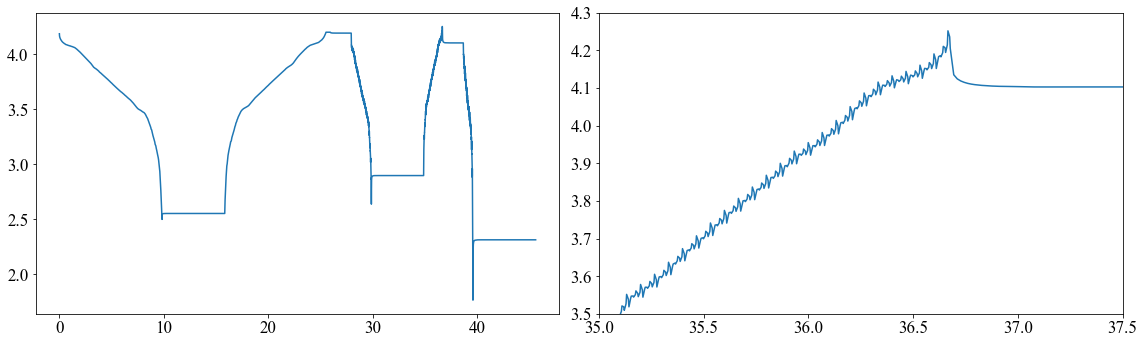

In [14]:
fig, axs = plt.subplots(1,2, figsize=(16,4.8),tight_layout=True)
axs[0].plot(t_1, V_1)
axs[1].plot(t_1, V_1)
axs[1].set_xlim([35,37.5])
axs[1].set_ylim([3.5,4.3])
#axs[2].plot(t_2, V_2)

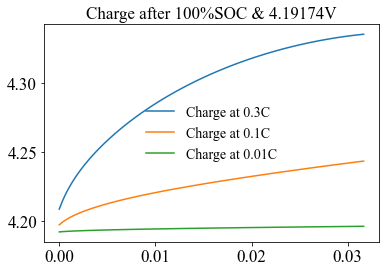

In [30]:
plt.plot(t_1, V_1,label='Charge at 0.3C')
plt.plot(t_2, V_2,label='Charge at 0.1C')
plt.plot(t_3, V_3,label='Charge at 0.01C')
plt.title('Charge after 100%SOC & 4.19174V') 
plt.legend(prop={'family':'Times New Roman','size':fs-3},loc='best',frameon=False)

In [7]:
t = Sol_0["Time [h]"].entries
I = Sol_0["Current [A]"].entries
Q = Sol_0["Discharge capacity [A.h]"].entries
V = Sol_0["Terminal voltage [V]"].entries

In [11]:
Sol_0.cycles[-1].steps[-1]["Terminal voltage [V]"].entries
#Sol_0.cycles[-1].steps[-2]["Terminal voltage [V]"].entries

array([4.19942573, 4.19669368, 4.19569814, 4.19502936, 4.19452292,
       4.19411771, 4.19378182, 4.1934956 , 4.19324794, 4.19303347,
       4.19284913, 4.19269196, 4.19255875, 4.19244639, 4.19235206,
       4.19227342, 4.19220854, 4.19215594, 4.19211471, 4.19208453,
       4.19206477, 4.19205036, 4.19203358, 4.19201862, 4.19201044,
       4.19200392, 4.19199339, 4.19198459, 4.19198219, 4.19198235,
       4.19197775, 4.19197208, 4.19197197, 4.19197627, 4.19197698,
       4.19197334, 4.19197327, 4.1919787 , 4.19198298, 4.1919808 ,
       4.19197873, 4.19198238, 4.19198854, 4.19198815, 4.19198198,
       4.19197784, 4.19197612, 4.19197042, 4.19196799, 4.19197692,
       4.19199281, 4.19200871, 4.19201595, 4.1920188 , 4.19202617,
       4.19203608, 4.19203841, 4.19203187, 4.19202621, 4.19202782,
       4.19203453, 4.19203359, 4.19201554, 4.19198592, 4.19195889,
       4.19195774, 4.19197538, 4.19198433, 4.19197275, 4.19195065,
       4.1919272 , 4.19190498, 4.19188422, 4.19186417, 4.19184

Clue: for the break-in test, the voltage during the 2hour rest peroid after 4.2V CV hold, decrease from 4.1994V to 4.1917V, decreasing by 8mV


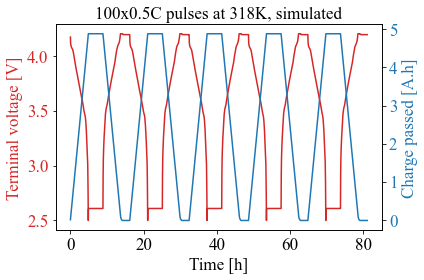

In [8]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time [h]')
ax1.set_ylabel('Terminal voltage [V]', color=color)
ax1.set_title('100x0.5C pulses at 318K, simulated')
ax1.plot(t, V, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Charge passed [A.h]', color=color)  # we already handled the x-label with ax1
ax2.plot(t, Q, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped